In [78]:
## IE 3311 Final Project Code File 
## Team JMC
## Jade Chanslor, Mason Reyna, Christian Curry

In [26]:
from gerrychain import Graph

In [28]:
# Read Kansas county graph from .json file
filename = 'C:/Users/Mason/Downloads/COUNTY_20.json'

# Use built-in GerryChain function to read graph
G = Graph.from_json(filename )

In [29]:
# Impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 4       # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 709714 and U = 716845 and k = 4


In [30]:
import gurobipy as gp
from gurobipy import GRB

# Create model 
m = gp.Model()

# Set variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

In [31]:
# Objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [32]:
# Constraint: each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# Constraint: each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# Constraint: edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [33]:

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G 
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [34]:
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [35]:
# solve LP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1957 rows, 1629 columns and 7937 nonzeros
Model fingerprint: 0x0400fca7
Variable types: 526 continuous, 1103 integer (1103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.09s
Presolved: 1957 rows, 1629 columns, 7937 nonzeros
Variable types: 526 continuous, 1103 integer (1103 binary)

Root relaxation: objective 0.000000e+00, 756 iterations, 0.11 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  436          -    0.00000      -     -    0s
     0     0    1.306

In [36]:
print("The number of cut edges is",m.objval)

# Retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# Rrint district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 32.0
District 0 has population 712582 and contains counties ['Greeley', 'Phillips', 'Pawnee', 'Clay', 'Republic', 'Seward', 'Ford', 'Marshall', 'Lincoln', 'Finney', 'Stanton', 'Sheridan', 'Ellis', 'Reno', 'Wabaunsee', 'Comanche', 'Logan', 'Harper', 'Norton', 'Thomas', 'Hamilton', 'Osborne', 'Hodgeman', 'Trego', 'Cloud', 'Dickinson', 'Lane', 'Cheyenne', 'Wallace', 'Kiowa', 'Haskell', 'Rice', 'Morton', 'Rush', 'Washington', 'McPherson', 'Ness', 'Grant', 'Edwards', 'Morris', 'Rooks', 'Barber', 'Decatur', 'Sherman', 'Gray', 'Barton', 'Clark', 'Saline', 'Kingman', 'Geary', 'Scott', 'Jewell', 'Wichita', 'Stevens', 'Graham', 'Kearny', 'Gove', 'Smith', 'Russell', 'Rawlins', 'Riley', 'Stafford', 'Ottawa', 'Meade', 'Mitchell', 'Ellsworth', 'Sumner', 'Pratt']
District 1 has population 712119 and contains counties ['Montgomery', 'Woodson', 'Chase', 'Cowley', 'Butler', 'Chautauqua', 'Harvey', 'Wilson', 'Elk', 'Sedgwick', 'Greenwood', 'Marion']
District 2 has population 71

In [74]:
# Draw it on a map
import geopandas as gpd
import networkx as nx

In [75]:
# Read Kansas county shapefile from "KS_counties.shp"
filename = 'C:/Users/Mason/Downloads/KS_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file(filename )

In [76]:
# Find column values
print(df.columns)

Index(['STATEFP20', 'COUNTYFP20', 'COUNTYNS20', 'GEOID20', 'NAME20',
       'NAMELSAD20', 'LSAD20', 'CLASSFP20', 'MTFCC20', 'CSAFP20', 'CBSAFP20',
       'METDIVFP20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20',
       'INTPTLON20', 'geometry'],
      dtype='object')


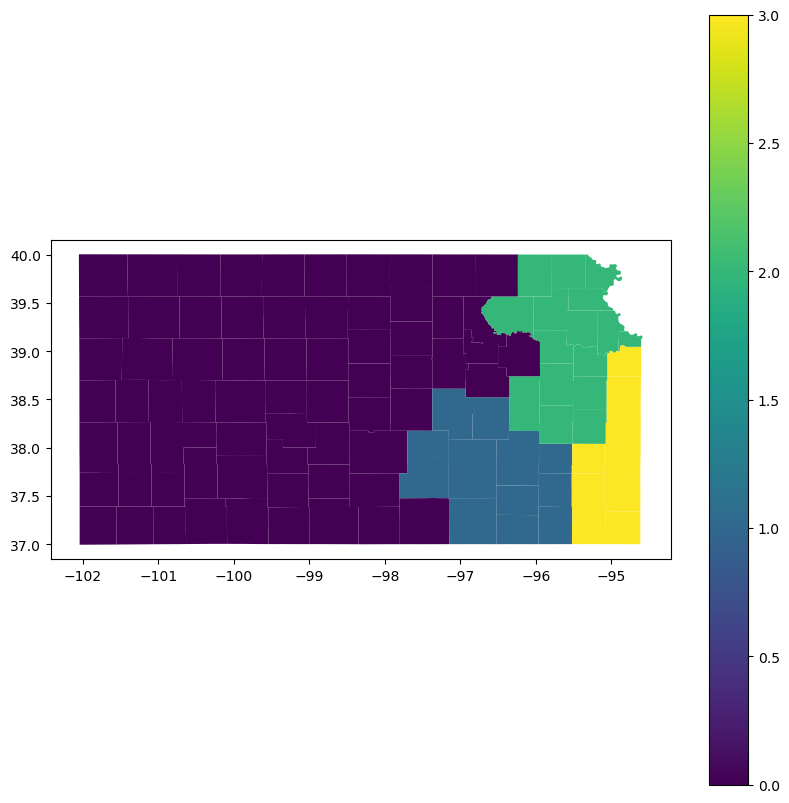

In [77]:
# Creating a variable for optimized districts 
district_info = {
    0: {
        'population': 712582,
        'counties': ['Greeley', 'Phillips', 'Pawnee', 'Clay', 'Republic', 'Seward', 'Ford', 'Marshall', 'Lincoln', 'Finney', 'Stanton', 'Sheridan', 'Ellis', 'Reno', 'Wabaunsee', 'Comanche', 'Logan', 'Harper', 'Norton', 'Thomas', 'Hamilton', 'Osborne', 'Hodgeman', 'Trego', 'Cloud', 'Dickinson', 'Lane', 'Cheyenne', 'Wallace', 'Kiowa', 'Haskell', 'Rice', 'Morton', 'Rush', 'Washington', 'McPherson', 'Ness', 'Grant', 'Edwards', 'Morris', 'Rooks', 'Barber', 'Decatur', 'Sherman', 'Gray', 'Barton', 'Clark', 'Saline', 'Kingman', 'Geary', 'Scott', 'Jewell', 'Wichita', 'Stevens', 'Graham', 'Kearny', 'Gove', 'Smith', 'Russell', 'Rawlins', 'Riley', 'Stafford', 'Ottawa', 'Meade', 'Mitchell', 'Ellsworth', 'Sumner', 'Pratt']
    },
    1: {
        'population': 712119,
        'counties': ['Montgomery', 'Woodson', 'Chase', 'Cowley', 'Butler', 'Chautauqua', 'Harvey', 'Wilson', 'Elk', 'Sedgwick', 'Greenwood', 'Marion']
    },
    2: {
        'population': 714395,
        'counties': ['Franklin', 'Jackson', 'Doniphan', 'Wyandotte', 'Lyon', 'Pottawatomie', 'Atchison', 'Brown', 'Jefferson', 'Nemaha', 'Osage', 'Leavenworth', 'Anderson', 'Shawnee', 'Coffey', 'Douglas']
    },
    3: {
        'population': 714022,
        'counties': ['Bourbon', 'Cherokee', 'Crawford', 'Allen', 'Johnson', 'Labette', 'Linn', 'Neosho', 'Miami']
    },
}

# Initialize assignment list with -1 for each row in GeoDataFrame
df['assignment'] = -1

# Iterate over district_info and assign districts to GeoDataFrame
for district, info in district_info.items():
    counties = info['counties']
    df.loc[df['NAME20'].isin(counties), 'assignment'] = district

# Plot the map
my_fig = df.plot(column='assignment', legend=True, figsize=(10, 10)).get_figure()

